In [ ]:
# импорт нужных библиотек
import keras
import tensorflow as tf
from keras import layers, losses, optimizers
import matplotlib.pyplot as plt
from keras.datasets import cifar100

## подготовка датасета

In [1]:
#задаем гиперпараметры
epochs = 5
batch_size = 10
#noise  в данном случае обозначает силу шума, применяется после скалирования
noise = 0.2
# скачиваем датасет
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()
#скалирование
train_images = train_images/255
test_images = test_images/255
# создаем датасет с шумом
train_noise = train_images + noise*tf.random.normal(shape=train_images.shape)
test_noise = test_images + noise*tf.random.normal(shape=test_images.shape)
# при создании шума пиксель может получиться > 1. ,
#а при использоании float matplotlib пиксель может быть максимум 1.0 ,
# сотвествено пришлось искать способ вернуться в рамки [0,1]
test_noise = tf.clip_by_value(test_noise, clip_value_min=0., clip_value_max=1.)
train_noise = tf.clip_by_value(train_noise, clip_value_min=0., clip_value_max=1.)


NameError: ignored

## создание модели

In [8]:
# можно было просто создать две модели encoder,decoder,
#но я решил в этот раз обойтись классом
class Autoencoder(keras.models.Model):
    def __init__(self, size):
        super(Autoencoder,self).__init__()
        # размер итогового слоя энкодера для линейной модели
        self.size = size
        '''
        # я решил вначалде попробовать через линейку,результат был весьма плохой
        # проблема в том что даже при переведении в нужный размер модель непонимала какой пиксель от чего,
        # и находила лишь общие очертания объекта в одном из трех измерений,но и то не всегда
        # с другой стороны это можно использовать для попытки сегментации изображений)
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(size, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(32*32*3, activation='sigmoid'),
            layers.Reshape((32, 32,3))
        ])
        '''
        #а это нормальная модель
        #вначале по привычке написал обычную сверточно-разверточную модель,
        #которая выдавала мне точно такую же картинку как и в начале)
        # но нам нужно именно кодирование в как можно меньший объем данных с наименьшими потерями
        # в итоге спустя пару часов экспериментов решил остановиться на данной архитектуре
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(32, 32, 3)),
            # при кодировании уменьшаем размерность(до 8х8)
            layers.Conv2D(16, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(8, 3, activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
            # при декодировании  восстанавливаем размерность,
            #но начинаем с большим количеством каналов для извлечения максимума информации из декодера
            # иначе картинка теряет цвет, или некоторые пиксели и картинка получится более размазанной
            layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(3, kernel_size=3, activation='sigmoid', padding='same')])

    def call(self, x):
      # объединение моеделей
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode

# созадем модель,смотрим что получилось
encod = Autoencoder(32*3)
print(encod.encoder.summary())
#завершаем настройку модели
# способ обучения -Adam, а вот вместо рекомендуемой MSE я выбрал MAE
# проблема в том что все значения в диапозаоне о 0 до 1
# а значит при допустим (1-0,5)**2  вместо лосса 0.5 будет 0.25 и штраф за ошибку будет меньше
# так что в моем понимании хоть и сильной разницы в лоссе я не обнаружил,
# на больших картинках я думаю эффективнее будет MAE
encod.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=losses.MeanAbsoluteError())

NameError: ignored

## тренировка модели

###  тренировка 1- на оригинальных картинках
#### сначала пробуем восстановить  изображение из оригинальной картинки
#### подаем модели картинку,и просим в конце вернуть ее же
#### ффактически нам нужны два результата-результат декодирования эндокера внутри модели,
#### и результат кодировки энкодера который в дальнейшим мог бы подаваться в text2image модель
#### но в нашем уроке 2 результат нам не нужен ,так что выводить его я не стал

In [ ]:
encod.fit(train_images, train_images,
          epochs=epochs, validation_data=(test_images, test_images), shuffle=True, batch_size=batch_size)
# тестируем своими глазками как модель справляется со соей задачей
enc_img = encod.encoder(test_images).numpy()
dec_img = encod.decoder(enc_img).numpy()
# выводим результат
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(3, 10, 1 + i)
    plt.imshow(test_images[i])
    plt.title(f'orig_img {i}')
    plt.xticks([])
    plt.yticks([])
    '''
    plt.subplot(3, 10, 11 + i)
    plt.title(f'noise {i}')
    plt.imshow(tf.squeeze(test_noise[i]))
    plt.xticks([])
    plt.yticks([])
    '''
    plt.subplot(3, 10, 21 + i)
    plt.title(f'decode_noise{i}')
    plt.imshow(dec_img[i])
    plt.xticks([])
    plt.yticks([])
plt.savefig('./zxc.jpg')


#### выводим что получилось
#### и забыл исправить название нижнего ряда,там реконструкция из обычных картинок,не зашумленных

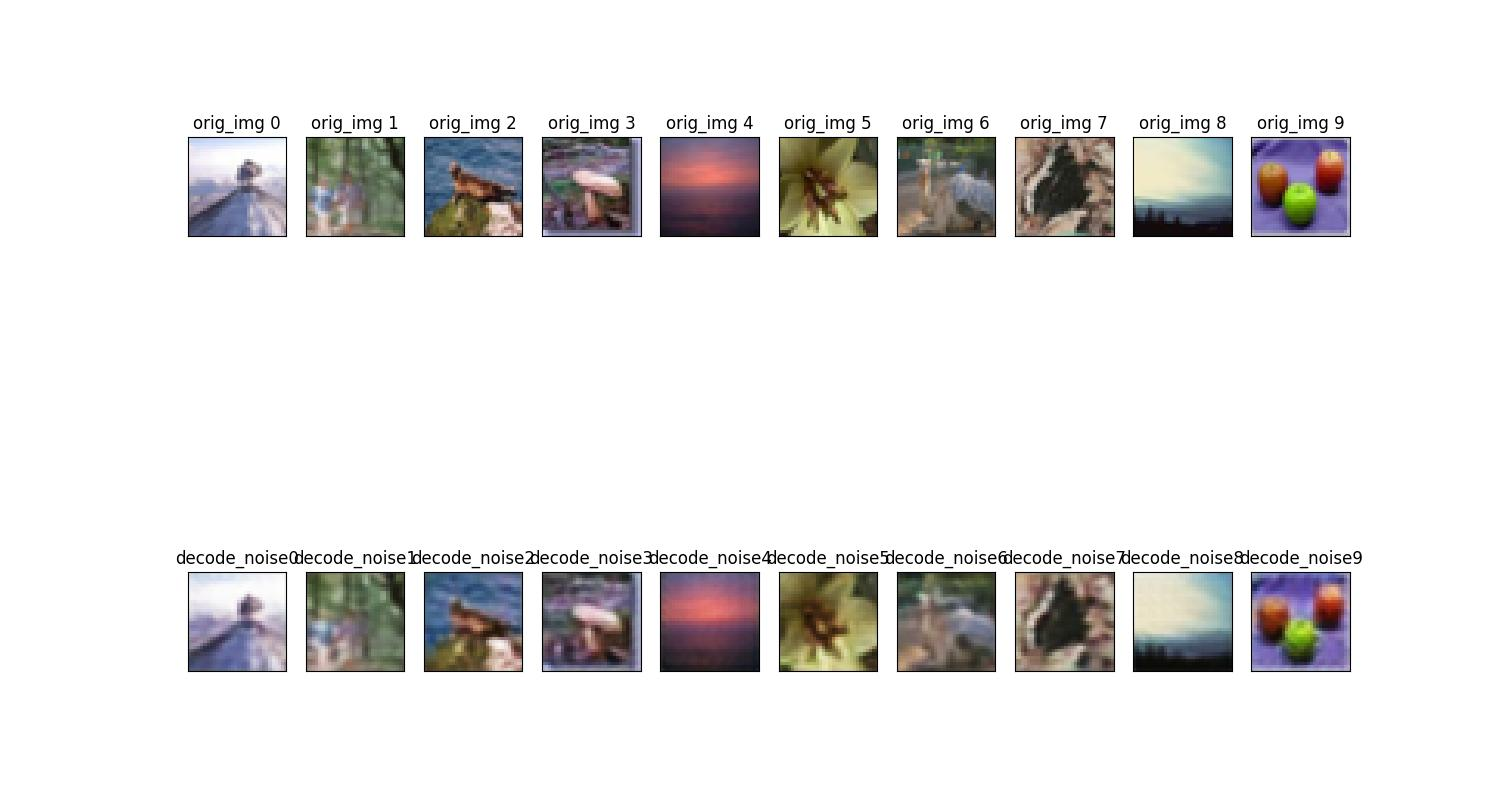

### как видим качество немного пострадало,но в целом модель неплохо справилась



### тренировка 2 - тренируемся на зашумленных картинках
#### здесь мы уже подаем на вход зашумленные картинки ,и при валидации просим восстановить зашумленные картинки
#### декодируем так же зашумленные картинки

In [ ]:
encod.fit(train_noise, train_images,
          epochs=epochs, validation_data=(test_noise, test_images), shuffle=True, batch_size=batch_size)
enc_img = encod.encoder(test_noise).numpy()
dec_img = encod.decoder(enc_img).numpy()
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(3, 10, 1 + i)
    plt.imshow(test_images[i])
    plt.title(f'orig_img {i}')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3, 10, 11 + i)
    plt.title(f'noise {i}')
    plt.imshow(tf.squeeze(test_noise[i]))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3, 10, 21 + i)
    plt.title(f'decode_noise{i}')
    plt.imshow(dec_img[i])
    plt.xticks([])
    plt.yticks([])
plt.savefig('./zxc.jpg')

### решил вывести обе для сравнения

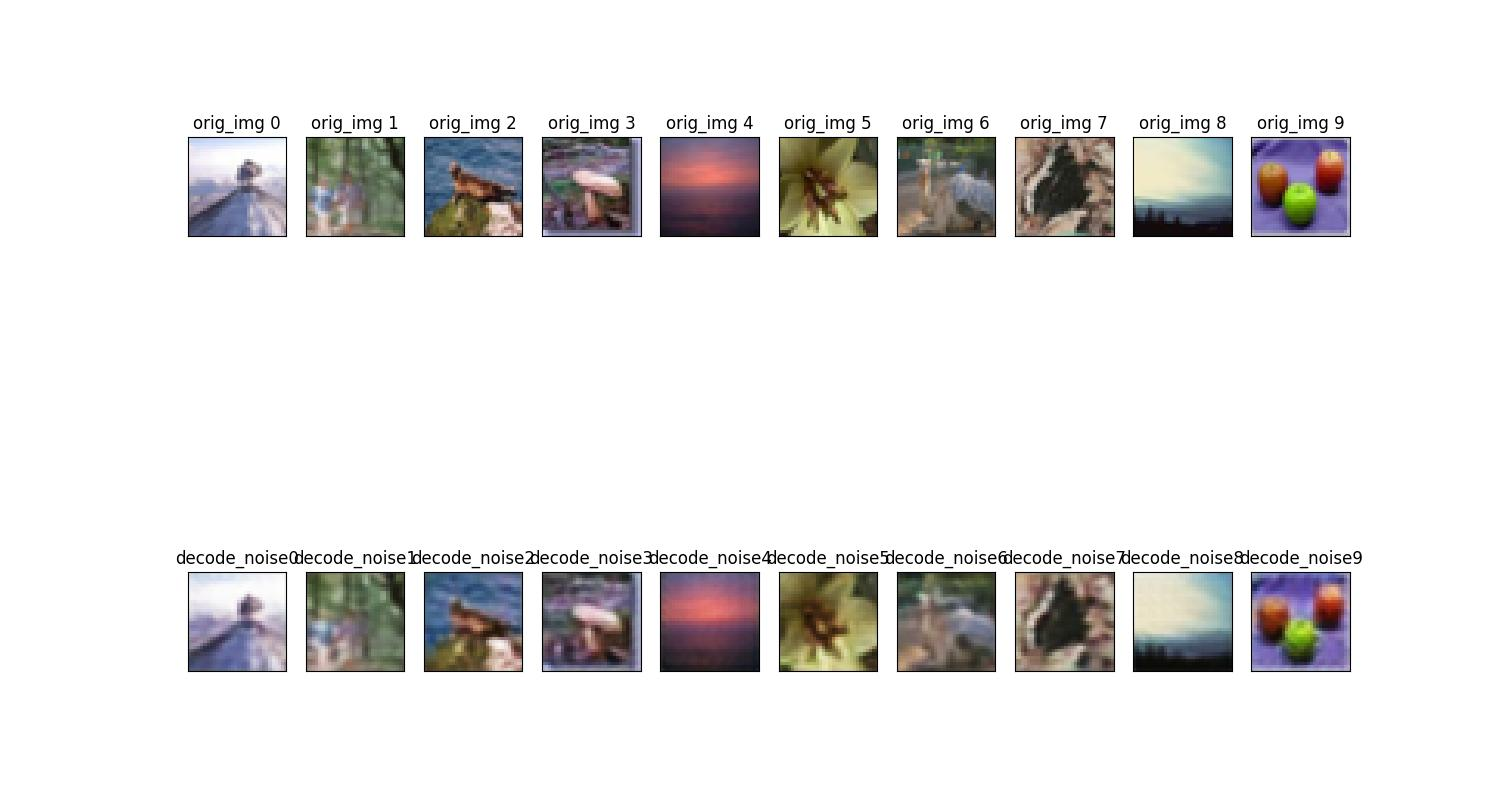

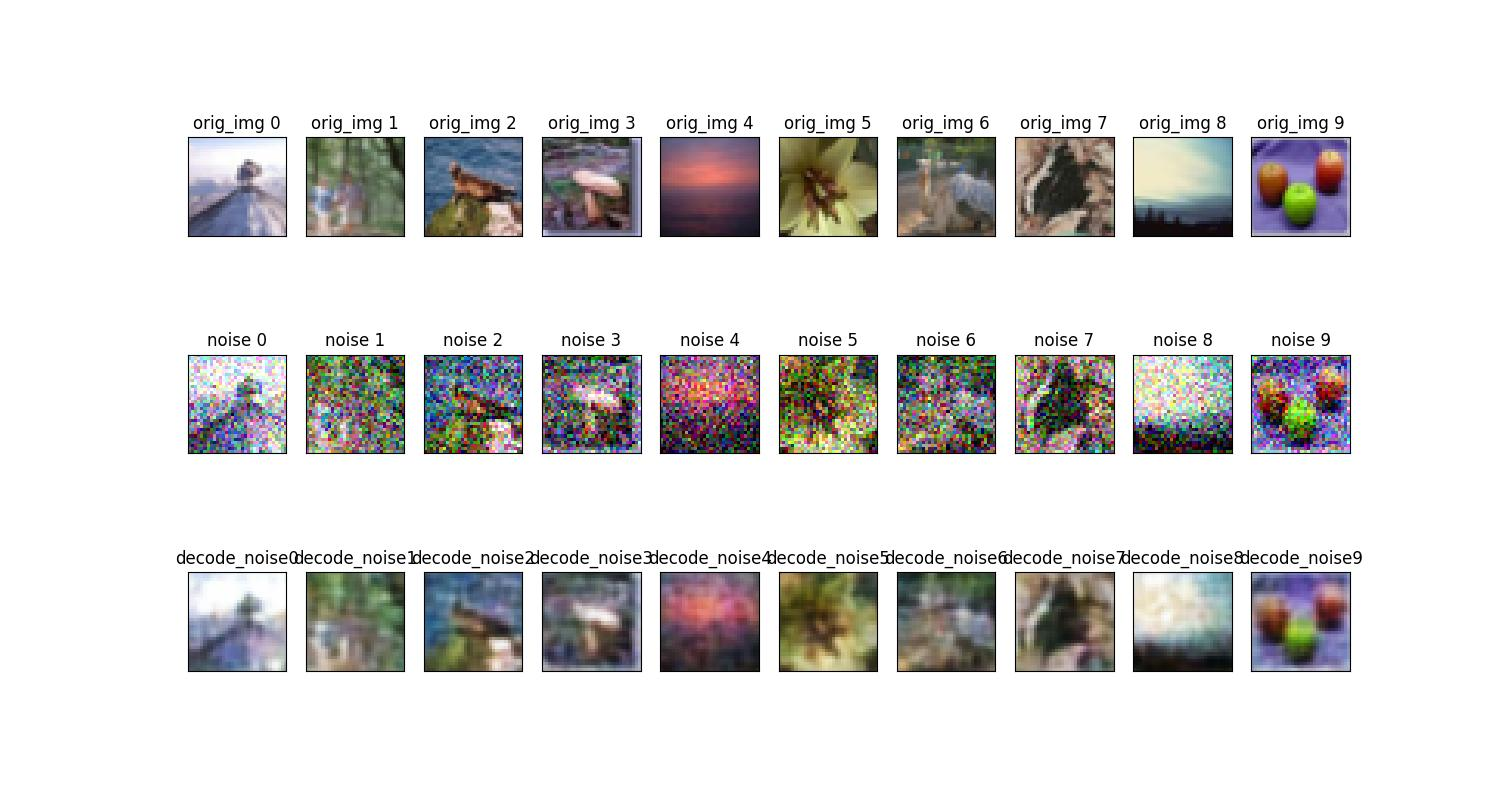

#### как видим качество при восстановлении зашумленных картинок хуже чем при обучении на оригинале,что ожидаемо, но в целом модель в большинстве случаев смогла восстановить очертания и цвет достаточно хорошо.

## выводы:
###  тот кто додумался до такого простого решения превращения слов в картинку-гений)
### ну а вообще в ходе экспериментов стало понятно что просто так картинку не закодируешь и не декодируешь, при малом количестве параметров модель плохо восстанавливает(хотя как я ответил это поидее можно использовать при сегментации я думаю)
### а если много параметров-результат отличный,только вот чем массивнее каждая закодированная картинка,тем больше нужно места еще и для текстовой модели,которая эти кодировки потом будет сопоставлять
### в общем нужен баланс,и  в первую очередь скорее даже понимание между тем ,какая модель нужна: быстро работающая или точная. можно конечнои то и то.но на это вероятно уйдут годы)